In [45]:
#################################### IMPORTS ###################################################
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import tensorflow as tf
import datetime
from keras.backend.tensorflow_backend import set_session

In [46]:
##################### INICIALIZACAO DE VARIAVEIS ################################################
index_arquivo = ['preco', 'hr_int', 'preco_pon', 'qnt_soma', 'max', 'min', 'IND', 'ISP'] #index do arquivo
steps = [] # 9h04 -> 17h50 a cada 5 segundos 
epocas = 10000 #quantidade de vezes que vai rodar todos os dias
janela = 10 #janela de valores
n_variaveis = len(index_arquivo) #'preco', 'hr_int', 'preco_pon', 'qnt_soma', 'max', 'min', 'IND', 'ISP'
n_entradas = n_variaveis * janela + 3 #ncont, valor, posicao e inputs
n_neuronios = 216 #numero de neuronios da camada escondida
n_saidas = 3 #nmero de saidas da rede (compra, vende, segura)
custo = 1.06/2 #custo da operao
melhor_reward = 0
posicao_max = 50 #define variavel para normalizar a posicao

versao_arquivo = 1

carregar_pesos = True
carregar_epoca_epsilon = False
epoca_init = 0
if carregar_epoca_epsilon:
    file = open("./epoca_epsilon.txt", "r")
    valores = file.read().split(',')
    epoca_init = int(valores[0])
    epsilon = float(valores[1])
    file.close()
else:
    epsilon = 1.0 #valor de epsilon
epsilon_min = 0.01 #valor minimo de epsilon
epsilon_decay = (epsilon - epsilon_min) / (epocas - epoca_init) #o valor que vai retirado do epsilon por epoca

rewards = [0] #variavel para guardar rewards
plotx = [0] #variavel para guardar valores a serem plotados do eixo x

In [47]:
####################### LEITURA DOS DADOS #######################################################
caminho_arquivo = ('./consolidado.csv')
arquivo = pd.read_csv(caminho_arquivo) #le arquivo
inputs = arquivo[index_arquivo]
if versao_arquivo == 1: #se quiser usar apenas os dias com IND e ISP
    inputs = inputs[inputs['IND'] != 0]
    arquivo = arquivo[arquivo['IND'] != 0]
pmax = np.amax( inputs.loc[:, inputs.columns[0]] ) #define valor minimo do preo
pmin = np.amin( inputs.loc[:, inputs.columns[0]] ) #define valor maximo do preo

for i in range( inputs.shape[1] ): #roda normalizo para todas as colunas
    imax = np.amax( inputs.loc[:, inputs.columns[i]] ) #pega valor maximo
    imin = np.amin( inputs.loc[:, inputs.columns[i]] ) #pega valor minimo
    inputs.loc[:, inputs.columns[i]] = ( inputs.loc[:, inputs.columns[i]] - imin ) / ( imax - imin ) #normaliza prs

dt = arquivo['dt'].values #cria coluna apenas dos dias
hr = arquivo['hr_int']/1000
steps = []
ultimo_dia = 0
dias_para_rodar = [] #variavel para colocar os dias a serem rodados
j = 0
for i in range( 0, len(dt) ):
    if (dt[i] != ultimo_dia):
        steps.append(i) #numero de linhas entre dias
        ultimo_dia = dt[i]
        dias_para_rodar.append(j) #numero do dia
        j += 1
dias = len(steps)
dias = 100

In [48]:
########################################   BIBLIOTECAS ####################################
import random
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras import backend as K            #importa backend para clear_session()

##################### MODELO DQN ####################################################
class DQNAgent:
    ########################### INICIALIZA ###########################################
    def __init__(self, state_size, action_size, epsilon, janela, n_neuronios, n_variaveis):
        self.state_size = state_size
        self.n_neuronios = n_neuronios
        self.action_size = action_size
        self.janela = janela
        self.n_variaveis = n_variaveis
        self.limpa_memoria()
        self.gamma = 0.90       # discount rate
        self.epsilon = epsilon  # exploration rate
        self.learning_rate = 0.001
        self.model = self.cria_modelo()
        self.model.summary()

################################# REDE NEURAL ###########################################
    def cria_modelo(self):
        # Neural Net for Deep-Q learning Model
        model = Sequential()
        model.add(Dense(self.n_neuronios, input_dim=self.state_size, activation='relu')) #camada de entrada (escondida)
        model.add(Dense(self.n_neuronios, activation='relu')) #camada escondida
        model.add(Dense(self.n_neuronios, activation='relu')) #camada escondida
        model.add(Dense(self.action_size, activation='softmax')) #camada de saida
        model.compile(loss='categorical_crossentropy', optimizer=tf.train.AdamOptimizer(learning_rate=self.learning_rate)) #compilador
        return model

    def limpa_memoria(self):
        self.state = np.empty((0,))
        self.next_state = np.empty((0,))
        
    def toma_acao(self, valores_ant, teste):
        if not teste and np.random.rand() <= self.epsilon: #se o numero aleatorio for menor que o epsilon
            return random.randrange(self.action_size) #retorna acao aleatoria
        estado = np.array([np.append(self.state, valores_ant)]) #cria valor de agora        
        act_values = self.model.predict(estado, batch_size=1) #calcula qual a melhor acao
        return np.argmax(act_values[0])  # returns action

    def treina_modelo(self, acao, reward, valores_ant, valores_dps, batch_size=1):
        prox_estado = np.array([np.append(self.next_state, valores_dps)]) #cria proximo estado
        target = (reward + self.gamma * np.amax(self.model.predict(prox_estado, batch_size=batch_size)[0])) #pega valor que quer chegar
        
        estado = np.array([np.append(self.state, valores_ant)]) #cria valor de agora
        target_f = self.model.predict(estado, batch_size=batch_size) #pega valor que chegou
        target_f[0][acao] = target #define o valor que deseja chegar
        
        self.model.fit(estado, target_f, epochs=1, verbose=0, batch_size=batch_size) #treina modelo
        
    def tira_ultimo_state(self):
        if self.state.shape[0] > self.janela * self.n_variaveis:
            self.state = self.state[self.n_variaveis:] #tira os ultimos preos
        if self.next_state.shape[0] > self.janela * self.n_variaveis:
            self.next_state = self.next_state[self.n_variaveis:] #tira os ultimos preos
        
    def carrega_pesos(self, name):
        self.model.load_weights(name) #carrega pesos

    def salva_pesos(self, name):
        self.model.save_weights(name) #salva pesos
        
########################  DECLARA MODELO ################################
modelo = DQNAgent(n_entradas, n_saidas, epsilon, janela, n_neuronios, n_variaveis)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_29 (Dense)             (None, 216)               18144     
_________________________________________________________________
dense_30 (Dense)             (None, 216)               46872     
_________________________________________________________________
dense_31 (Dense)             (None, 216)               46872     
_________________________________________________________________
dense_32 (Dense)             (None, 3)                 651       
Total params: 112,539
Trainable params: 112,539
Non-trainable params: 0
_________________________________________________________________


In [49]:
########################### FUNCOES ###############################################################

def atuacao( preco, ncont, acao, custo, valor ):  #preo atual, n de contratos posicionados,
                                                #ao atual, custo, valor da posio
    valor_cheio = 0.
    ncont_anterior = ncont #salva posio anterior
    ncont += acao #posio atual = pos anterior + ao
    
    if valor != 0:
        valor_cheio = ( valor * ( pmax - pmin ) + pmin )  #valor posicionado atual

    dp = ( preco * ( pmax - pmin ) + pmin ) - valor_cheio #variao do preo atual e do preo de compra/venda
    posicao = ncont_anterior * dp * 10 - custo * abs(acao) #posicao = lucro - custo (INSTANTNEO)

    #calculos sobre o valor    
    if ( ncont_anterior == 0 and acao != 0 ): #primeiro valor
        valor = preco
    elif ( ncont == 0 ):
        valor = 0
    #caso nao se encaixe nessas condies: valor = valor (nada muda)

    return ncont, valor, posicao, ncont_anterior

def obter_acao(ncont, valores_ant):
    decisao = modelo.toma_acao(valores_ant, False) #calcula a saida da rede neural

    if decisao == 0: #comprar
        if ncont == 0: #s compra se no tem nada ainda
            return 1
    elif decisao == 1: #vender
        if ncont == 1: #s vende se tiver alguma coisa
            return -1
    return 0 #neutro

def rodar_1dia(precos, custo, dia):
    global melhor_reward
    ncont = 0 #cria variavel de quantidade de contratos
    ncont_anterior = 0 #cria variavel para quantidade de contratos anterior
    valor = 0 #cria variavel para preo medio
    reward = 0 #cria variavel para recompensa
    posicao = 0 #cria variavel de posio 
    modelo.limpa_memoria() #limpa o vetor de memoria
    
    for step in range( steps[dia - 1], steps[dia] ):  #roda os dados
        
        ultimos_precos = precos[ step : step + 1 ] #pega os valores de agora
        modelo.state = np.append( modelo.state, ultimos_precos ) #adiciona na variavel de estado
        
        modelo.tira_ultimo_state()
        valores_ant = [ncont, valor, posicao / posicao_max] #grava os valores de antes

        if modelo.state.shape[0] == janela * n_variaveis: #se ja tem memoria suficiente
            acao = obter_acao( ncont, valores_ant ) #obtem ao
            ncont, valor, posicao, ncont_anterior = atuacao(precos['preco'][step], ncont, acao, custo, valor)
            if ( ncont_anterior != ncont ): #reward acumulado recebe reward instantaneo somente se houver lucro/prejuizo real   
                reward += posicao #soma reward
                #print("acao: {0} reward: {1} hora: {2}".format(acao, reward, str(datetime.timedelta(seconds=hr[step]))))
            
        prox_precos = precos[ step + 1 : step + 2 ] #pega os proximos valores
        modelo.next_state = np.append(modelo.next_state, prox_precos) #adiciona variavel na variavel de proximo estado
        modelo.tira_ultimo_state()
        valores_dps = [ncont, valor, posicao / posicao_max] #grava os valores de depois
        
        if modelo.state.shape[0] == janela * n_variaveis: #se ja tem memoria suficiente
            modelo.treina_modelo(acao, posicao / posicao_max, valores_ant, valores_dps) #roda o modelo
            
    reward += posicao - custo * abs(ncont) #soma reward - DAY-TRADE (obs: custo nao havia sido considerado no reward pq acao era 0)
    if reward > melhor_reward:
        melhor_reward = reward
    return reward #retorna o valor do reward

dias_pos = 0
dias_neg = 0

def rodar_dias(precos, custo):   
    global dias_pos
    global dias_neg
    sum_rewards = 0 #cria variavel de somatoria de recompensas
    for dia in range( 1, dias ): #loop de dias
        reward = rodar_1dia(precos, custo, dia)
        sum_rewards += reward #roda 1 dia e adiciona o total na variavel de somatoria
        #print("dia {0} de {1}: R$ {2:0.2f}".format(dia, dias, reward)) #mostra o resultado do dia
        if reward>0: 
            dias_pos += 1
        elif reward<0:
            dias_neg += 1
    return sum_rewards


resultado da epoca 0 = 2173.49
resultado da epoca 1 = 2204.32
resultado da epoca 2 = 2336.60
resultado da epoca 3 = 1838.26
resultado da epoca 4 = 1879.02
resultado da epoca 5 = 1642.43
resultado da epoca 6 = 2111.44
resultado da epoca 7 = 2193.79
resultado da epoca 8 = 1961.60
resultado da epoca 9 = 2535.01
resultado da epoca 10 = 1970.84
resultado da epoca 11 = 1925.61
resultado da epoca 12 = 2025.38
resultado da epoca 13 = 1988.49
resultado da epoca 14 = 1846.90
resultado da epoca 15 = 2205.08
resultado da epoca 16 = 2070.68
resultado da epoca 17 = 1881.14
resultado da epoca 18 = 1993.03
resultado da epoca 19 = 2426.97
resultado da epoca 20 = 2151.14
resultado da epoca 21 = 2031.44
resultado da epoca 22 = 1795.01
resultado da epoca 23 = 1911.37
resultado da epoca 24 = 1807.43
resultado da epoca 25 = 1910.08
resultado da epoca 26 = 1887.20
resultado da epoca 27 = 2179.62
resultado da epoca 28 = 2026.14
resultado da epoca 29 = 2200.61
resultado da epoca 30 = 2163.49
resultado da epoca

resultado da epoca 252 = 1501.14
resultado da epoca 253 = 2422.43
resultado da epoca 254 = 1968.56
resultado da epoca 255 = 2166.74
resultado da epoca 256 = 2011.44
resultado da epoca 257 = 1845.84
resultado da epoca 258 = 1789.78
resultado da epoca 259 = 1868.26
resultado da epoca 260 = 1661.60
resultado da epoca 261 = 1851.14
resultado da epoca 262 = 2159.55
resultado da epoca 263 = 2178.26
resultado da epoca 264 = 1875.84
resultado da epoca 265 = 2031.67
resultado da epoca 266 = 1719.02
resultado da epoca 267 = 2142.73
resultado da epoca 268 = 2011.44
resultado da epoca 269 = 1460.31
resultado da epoca 270 = 1985.61
resultado da epoca 271 = 1881.14
resultado da epoca 272 = 2315.61
resultado da epoca 273 = 2085.15
resultado da epoca 274 = 2002.43
resultado da epoca 275 = 1606.37
resultado da epoca 276 = 1950.15
resultado da epoca 277 = 2415.38
resultado da epoca 278 = 1967.96
resultado da epoca 279 = 2175.68
resultado da epoca 280 = 2064.02
resultado da epoca 281 = 1896.37
resultado 

resultado da epoca 501 = 1725.38
resultado da epoca 502 = 1868.79
resultado da epoca 503 = 2091.90
resultado da epoca 504 = 1395.01
resultado da epoca 505 = 2326.67
resultado da epoca 506 = 2109.32
resultado da epoca 507 = 2013.49
resultado da epoca 508 = 1564.62
resultado da epoca 509 = 2203.26
resultado da epoca 510 = 1924.25
resultado da epoca 511 = 1929.32
resultado da epoca 512 = 2216.21
resultado da epoca 513 = 1953.56
resultado da epoca 514 = 1354.85
resultado da epoca 515 = 2276.67
resultado da epoca 516 = 1584.18
resultado da epoca 517 = 2113.49
resultado da epoca 518 = 1669.02
resultado da epoca 519 = 2104.85
resultado da epoca 520 = 1980.84
resultado da epoca 521 = 1970.31
resultado da epoca 522 = 2306.90
resultado da epoca 523 = 1931.14
resultado da epoca 524 = 1897.43
resultado da epoca 525 = 1990.84
resultado da epoca 526 = 2184.48
resultado da epoca 527 = 2622.50
resultado da epoca 528 = 2824.85
resultado da epoca 529 = 2001.90
resultado da epoca 530 = 2154.78
resultado 

resultado da epoca 750 = 1849.32
resultado da epoca 751 = 1672.50
resultado da epoca 752 = 2150.61
resultado da epoca 753 = 2561.37
resultado da epoca 754 = 1911.60
resultado da epoca 755 = 1960.08
resultado da epoca 756 = 1971.44
resultado da epoca 757 = 2014.09
resultado da epoca 758 = 1836.14
resultado da epoca 759 = 2297.20
resultado da epoca 760 = 2179.02
resultado da epoca 761 = 1916.83
resultado da epoca 762 = 2772.96
resultado da epoca 763 = 1914.62
resultado da epoca 764 = 2764.25
resultado da epoca 765 = 2160.22
resultado da epoca 766 = 1752.73
resultado da epoca 767 = 2119.02
resultado da epoca 768 = 2078.26
resultado da epoca 769 = 2291.44
resultado da epoca 770 = 2091.44
resultado da epoca 771 = 1740.01
resultado da epoca 772 = 1995.24
resultado da epoca 773 = 1438.79
resultado da epoca 774 = 2022.96
resultado da epoca 775 = 1957.20
resultado da epoca 776 = 2159.02
resultado da epoca 777 = 1684.85
resultado da epoca 778 = 2250.61
resultado da epoca 779 = 2089.02
resultado 

resultado da epoca 999 = 2123.79
resultado da epoca 1000 = 2229.02
resultado da epoca 1001 = 1939.85
resultado da epoca 1002 = 2334.32
resultado da epoca 1003 = 2244.32
resultado da epoca 1004 = 1717.66
resultado da epoca 1005 = 1575.75
resultado da epoca 1006 = 2046.14
resultado da epoca 1007 = 1182.66
resultado da epoca 1008 = 2256.44
resultado da epoca 1009 = 1842.96
resultado da epoca 1010 = 2338.56
resultado da epoca 1011 = 2177.43
resultado da epoca 1012 = 2153.86
resultado da epoca 1013 = 1826.21
resultado da epoca 1014 = 1910.54
resultado da epoca 1015 = 1703.49
resultado da epoca 1016 = 2219.32
resultado da epoca 1017 = 1778.26
resultado da epoca 1018 = 1714.55
resultado da epoca 1019 = 1744.32
resultado da epoca 1020 = 1990.68
resultado da epoca 1021 = 2245.84
resultado da epoca 1022 = 1813.49
resultado da epoca 1023 = 2283.26
resultado da epoca 1024 = 2027.66
resultado da epoca 1025 = 1819.32
resultado da epoca 1026 = 1862.43
resultado da epoca 1027 = 2032.20
resultado da ep

KeyboardInterrupt: 

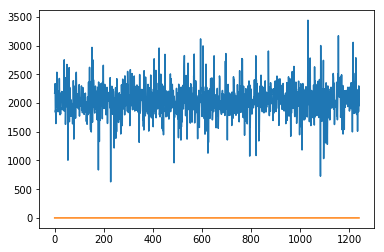

In [50]:
import time
##################################  MAIN  #########################################
if __name__ == "__main__":
    global dias_pos
    global dias_neg
    sum_rewards_total = 0
    modelo.epsilon = 0.01
    sr=[]
    try:
        if carregar_pesos:
            modelo.carrega_pesos('./pesos.h5')
        epoca_parou = epoca_init
        for epoca in range(epoca_init, epocas): #rodar uma quantidade de epocas
            #s=time.time()
            #print("epoca {0}\n".format(epoca)) #mostra que epoca vai rodar
            sum_rewards = rodar_dias(inputs, custo) #adiciona o resultado da epoca na somatoria
            sum_rewards_total += sum_rewards
            sr.append(sum_rewards)
            print("resultado da epoca {0} = {1:0.2f}".format(epoca, sum_rewards))
            epoca_parou += 1
            if ((epoca % 200) == 0):
                modelo.salva_pesos('./pesos.h5')
            #e=time.time()
            #print(e-s)
            #modelo.epsilon -= epsilon_decay
    finally:
        print(dias_pos)
        print(dias_neg)
        modelo.salva_pesos('./pesos.h5')
        if carregar_epoca_epsilon:
            file = open("./epoca_epsilon.txt", "w")
            file.writelines("{0},{1}".format(epoca_parou, modelo.epsilon))
            file.close()
            print("parou na epoca {0} com epsilon {1}".format(epoca_parou, modelo.epsilon))
        print("Somatoria dos rewards: {0:0.2f}".format(sum_rewards_total))
        print("Melhor resultado diario: {0:0.2f}".format(melhor_reward))
        plt.plot(range(0, len(sr)), sr, range(0, len(sr)), np.zeros(len(sr))) #plota os valores de reward por epoca